In [1]:
# Copyright (c) 2020 Urbain Vaes. All rights reserved.
#
# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rc('font', size=20)
matplotlib.rc('font', family='serif')
matplotlib.rc('figure', figsize=(14, 8))
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('lines', markersize=10)
matplotlib.rc('figure.subplot', hspace=.4)

# Taylor methods for stochastic differential equations

In [3]:
def stochastic_integrator(t, x0_gen, drift, diff, m,
                          method="EM", diff_prime=None,
                          save_paths=True):
    """ Euler-Maruyama and Milstein schemes

    :t: Vector of times
    :x0_gen: Sampler for the initial condition
    :drift: Drift coefficient
    :diff: Diffusion coefficient
    :m: Number of replicas
    :method: Method to use (EM or Milstein)
    :diff_prime: Derivative of the diffusion coefficient (for Milstein)
    :save_paths: Return full paths or just final time
    """

    def step_em(x, dt):
        dw = np.sqrt(dt) * np.random.randn(len(x))
        return x + drift(x) * dt + diff(x) * dw, dw

    def step_milstein(x, dt):
        dw = np.sqrt(dt) * np.random.randn(len(x))
        extra_term = 1/2 * (diff_prime(x) * diff(x)) * (dw**2 - dt)
        return x + drift(x) * dt + diff(x) * dw + extra_term, dw

    step = step_em if method == "EM" else step_milstein
    n_times = len(t)

    if save_paths:

        # Matrix to store the solutions
        result = np.zeros((n_times, m))
        result[0] = x0_gen(m)

        # Matrix to store the Brownian motions (in order to
        # compute the exact solution - see below)
        w = np.zeros((n_times, m))

        for i in range(n_times - 1):
            result[i + 1], dw = step(result[i], t[i+1] - t[i])
            w[i + 1] = w[i] + dw

        return result, w

    # If we want only the solution at the final time
    result = x0_gen(m)
    w = np.zeros(m)

    for i in range(n_times - 1):
        result, dw = step(result, t[i+1] - t[i])
        w += dw

    return result, w

# Simulation parameters
T, n, m = 5, 100, 20

# Vector of times
t = np.linspace(0, T, n + 1)


We first illustrate the Euler-Maruyama for the Ornstein–Uhlenbeck process
$$
\newcommand{\d}{\mathrm d}
\newcommand{\e}{\mathrm e}
\newcommand{\cov}{\mathrm{cov}}
\newcommand{\var}{\mathrm{var}}
\d X_t = \theta (\mu -  X_t) \, \d t + \sigma \, \d W_t.
$$
During the lecture, we showed that the solution to this equation is given by
$$
X_t = \mu + \e^{-\theta t} (X_0 - \mu) + \int_0^t \e^{-\theta (t - s)} \, \d W_s.
$$
It is clear that the of the solution is $\mu(t) = \mu + \e^{-\theta t} (\mathbb E[X_0] - \mu)$.
Employing the fact that the initial condition is independent of the Brownian
motion (which we always assume so that the hypotheses of the theorem on the
existence and uniqueness of a strong solution are satisfied)
and using Itô's isometry,
we calculate, for $t \geq s$
$$
\begin{aligned}
\cov(X_s, X_t)
&= \var(X_0) \, \e^{-\theta (t + s)} + \sigma^2 \, \e^{-\theta (t + s)} \, \mathbb E \left[\int_0^s e^{\theta u} \, \d W_u \, \int_0^t e^{\theta u} \, \d W_u \right] \\
&= \var(X_0) \, \e^{-\theta (t + s)} + \sigma^2 \, \e^{-\theta (t + s)} \, \mathbb E \left[\int_0^s e^{\theta u} \, I_{[0, s]}(u) \, \d W_u \, \int_0^t e^{\theta u} \, \d W_u \right] \\
&= \var(X_0) \, \e^{-\theta (t + s)} + \sigma^2 \, \e^{-\theta (t + s)} \, \int_0^t \e^{2 \theta \, u} \, I_{[0, s]}(u) \, \d u \\
&= \var(X_0) \, \e^{-\theta (t + s)} + \frac{\sigma^2}{2\theta} \, (\e^{-\theta (t - s)} - \e^{-\theta (t + s)}).
\end{aligned}
$$
Since $\cov(X_s, X_t)$ must be symmetric, we deduce that in general
$\cov(X_s, X_t) = \var(X_0) \, \e^{-\theta (t + s)} + \frac{\sigma^2}{2\theta} \, (\e^{-\theta |t - s|} - \e^{-\theta (t + s)})$.

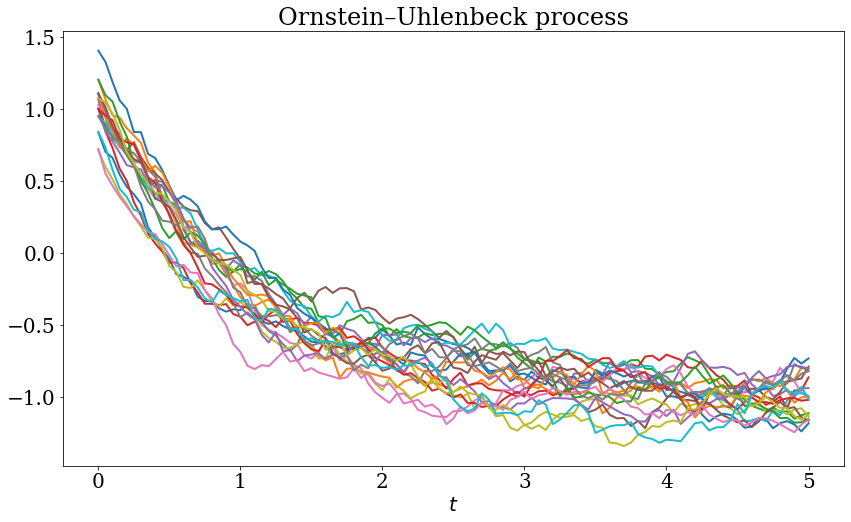

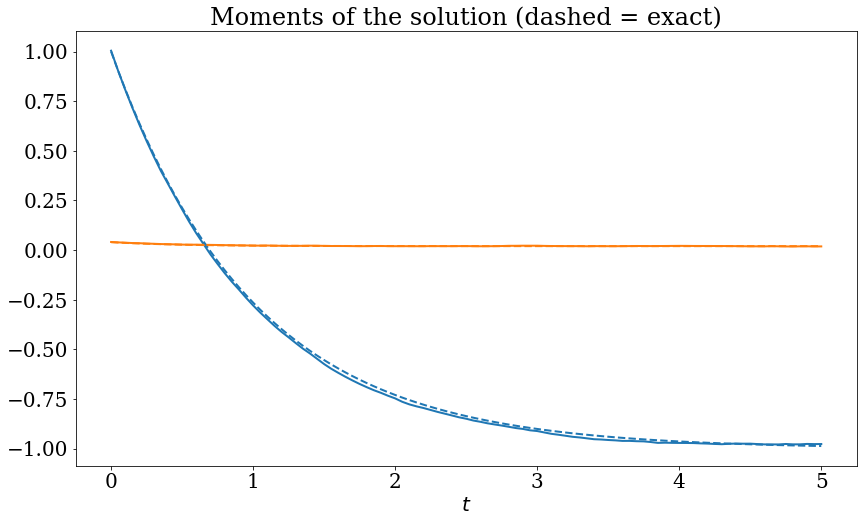

In [4]:
# Parameters for the OU process
mu, theta, sigma = -1, 1, .2

# Drift and diffusion coefficients
drift = lambda x: theta*(mu - x)
diff = lambda x: sigma

# Initial condition, here ~ N(1, 1/25)
m0, s0 = 1, 1/5
x0 = lambda m: m0 + s0*np.random.randn(m)

# Calculate solution by stochastic_integrator
x, _ = stochastic_integrator(t, x0, drift, diff, m)

# Plot of the solution
fig, ax = plt.subplots()
ax.set_title("Ornstein–Uhlenbeck process")
ax.set_xlabel("$t$")
ax.plot(t, x)
plt.show()

# Compare with exact moments
fig, ax = plt.subplots()
x, _ = stochastic_integrator(t, x0, drift, diff, 10**3)
exact_mean = mu + np.exp(-theta*t)*(m0 - mu)
exact_var = s0**2 * np.exp(-2*theta*t) + sigma**2/2/theta * (1 - np.exp(-2*theta*t))
ax.set_title("Moments of the solution (dashed = exact)")
ax.set_xlabel("$t$")
ax.plot(t, np.mean(x, axis=1))
ax.plot(t, np.var(x, axis=1))
# Reset color cycle
ax.set_prop_cycle(None)
ax.plot(t, exact_mean, linestyle="--")
ax.plot(t, exact_var, linestyle="--")
plt.show()

# Strong order of convergence
Here we consider geometric Brownian motion, for which an
exact solution is available:
$$
\d X_t = \mu \, X_t \, \d t + \sigma \, X_t \, \d t.
$$

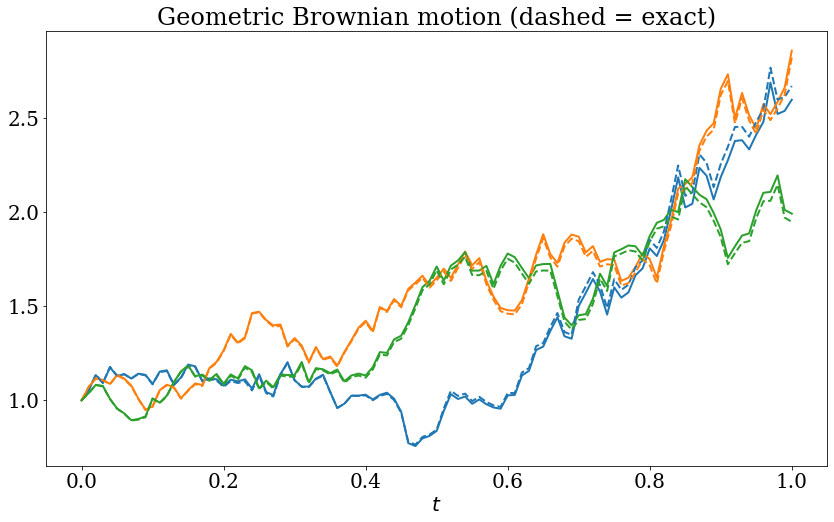

In [5]:
# Parameters of the equation
mu, sigma = 1, .5

# Simulation parameters
T, n, m = 1, 100, 3

# Vector of times
t = np.linspace(0, T, n + 1)

# Drift and diffusion coefficients
drift = lambda x: mu*x
diff = lambda x: sigma*x
diff_prime = lambda x: sigma

# Initial condition, here deterministic
x0_deterministic = 1
x0 = lambda m: x0_deterministic * np.ones(m)

# Euler-Maruyama
x, w = stochastic_integrator(t, x0, drift, diff, m)

def exact_solution(t, w):
    # Make t a matrix, so that Python can do (t + w)
    t.shape = (len(t), 1)
    return x0_deterministic * np.exp((mu - sigma**2/2)*t + sigma * w)

# Plot of the solution
fig, ax = plt.subplots()
ax.set_xlabel("$t$")
ax.set_title("Geometric Brownian motion (dashed = exact)")
ax.plot(t, x)
ax.set_prop_cycle(None)
ax.plot(t, exact_solution(t, w), linestyle="--")
plt.show()

We calculate the strong order of convergence by looking at the dependence on the time step $\Delta t$ of the total strong error:
$$
\varepsilon = \mathbb E \left[ \sup_{n \Delta t \leq T} |X^{\Delta t}_n - X_{n\Delta t}| \right].
$$
Here $X_t$ denotes the exact solution and $X^{\Delta t}_n$
denotes the numerical solution with time step $\Delta t$ at step $n$
An alternative would have been to look at the strong error
at the final time:
$$
\varepsilon_T = \mathbb E |X^{\Delta t}_{T/\Delta t} - X_{T}|.
$$

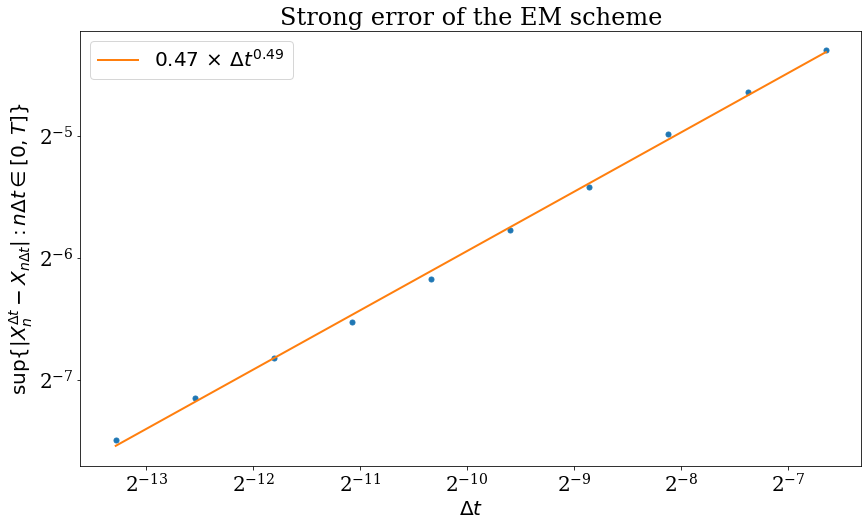

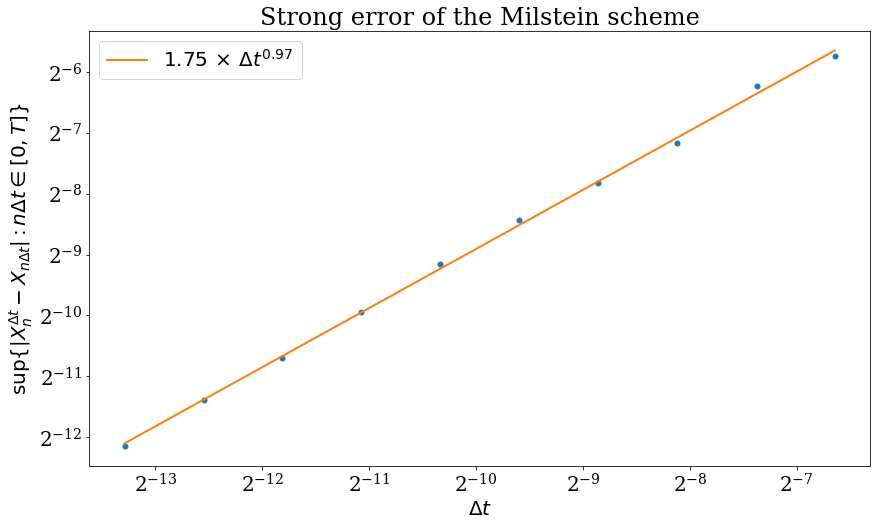

In [6]:
# Auxiliary function to plot the error
def plot_errors(Δts, errors, error_type, method):
    # Fit to estimate order of convergence
    coeffs = np.polyfit(np.log2(Δts), np.log2(errors), 1)

    # Plot
    fig, ax = plt.subplots()
    ax.set_title("{} error of the {} scheme".format(error_type, method))
    if error_type == "Strong":
        ylabel = r"$\sup \{ |X^{\Delta t}_n  - X_{n \Delta t}|:" \
                + "n \Delta t \in [0, T] \}$"
    elif error_type == "Weak":
        ylabel = r"$|E[f(X^{\Delta t}_{T/\Delta t}] - E[f(X_t)] |$"
    ax.set_xlabel(r"$\Delta t$")
    ax.set_ylabel(ylabel)
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)
    ax.plot(Δts, errors, linestyle='', marker='.')
    ax.plot(Δts, 2**coeffs[1] * (Δts)**coeffs[0],
            label=r'${:.2f} \, \times \, \Delta t^{{ {:.2f} }}$'.
            format(2**coeffs[1], coeffs[0]))
    ax.legend()
    plt.show()

def strong_error(x, x_exact):
    sup_interval = np.max(np.abs(x - x_exact), axis=0)
    return np.mean(sup_interval)

m, len_ns = 300, 10
ns = np.logspace(2, 4, len_ns)
ns = np.array([int(n) for n in ns])
strong_errors = np.zeros(len_ns)

def calculate_strong_order(method):
    for i, n in enumerate(ns):
        t = np.linspace(0, T, n)
        x, w = stochastic_integrator(t, x0, drift, diff, m,
                                     method=method, diff_prime=diff_prime)
        x_exact = exact_solution(t, w)
        strong_errors[i] = strong_error(x, x_exact)
    plot_errors(T/ns, strong_errors, "Strong", method)

calculate_strong_order("EM")
calculate_strong_order("Milstein")

# Weak order of convergence
Here we consider again geometric Brownian motion, and we
will estimate the weak error at the final time for the
observable $f(x) = x$, i.e. we will estimate
$$
\varepsilon = | \mathbb E [X^{\Delta t}_{T/\Delta t}] - \mathbb E [X_{T}] |.
$$
The weak order of convergence is much more difficult to confirm numerically,
because an accurate estimation requires that the Monte Carlo error on
$\mathbb E [X^{\Delta t}]$ be small in comparison with the weak error.
For this reason, we select below parameters such that the system is only a
little noisy - the deterministic part of the dynamics dominates.
Our choice of the parameters $\mu$ and $\sigma$ is taken from Des Higham's
[introduction to the numerical solution of stochastic differential equations](https://epubs.siam.org/doi/pdf/10.1137/S0036144500378302).

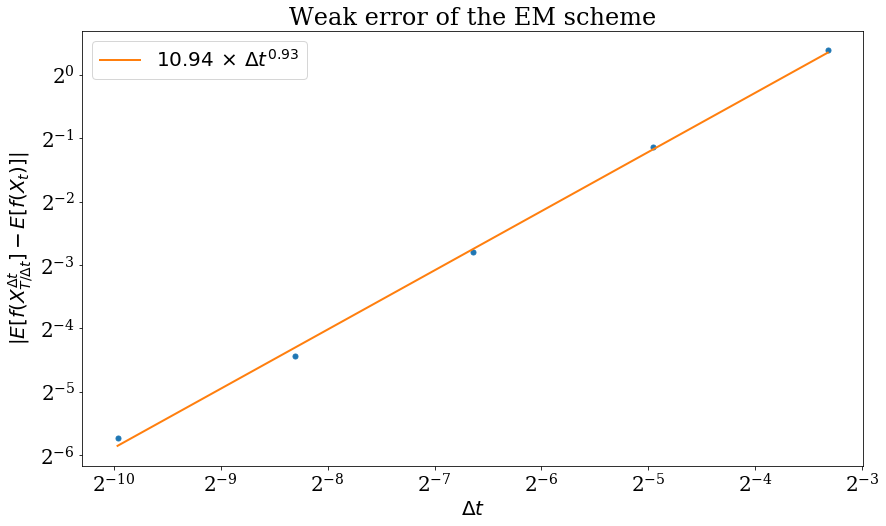

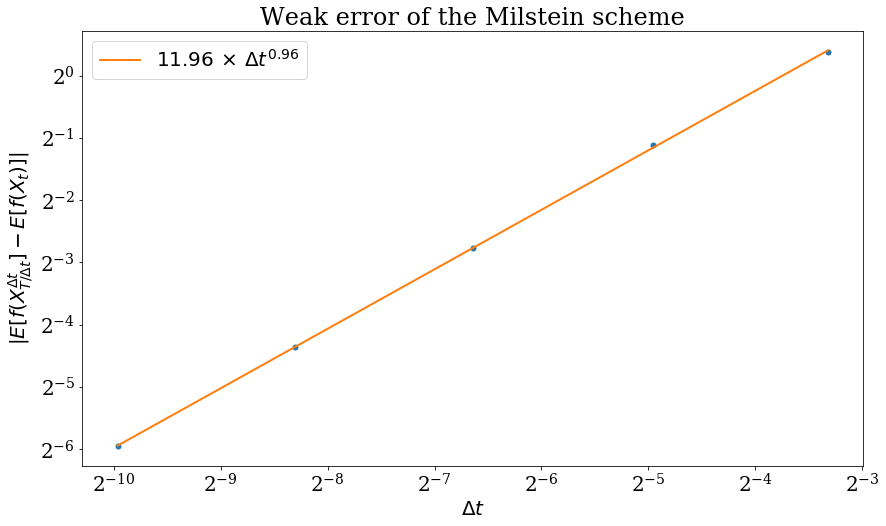

In [7]:
m, len_ns = 10**5, 5
ns = np.logspace(1, 3, len_ns)
ns = np.array([int(n) for n in ns])
weak_errors = np.zeros(len_ns)

# Simulation parameters
t = np.linspace(0, T, n + 1)

# Parameters
mu, sigma = 2, .1

# Drift and diffusion coefficients
drift = lambda x: mu*x
diff = lambda x: sigma*x
diff_prime = lambda x: sigma

def calculate_weak_order(method):
    for i, n in enumerate(ns):
        t = np.linspace(0, T, n)

        # Array to store the value of the numerical solution
        # at the last iteration
        result = []
        result, _ = stochastic_integrator(
                t, x0, drift, diff, m, method=method,
                diff_prime=diff_prime, save_paths=False)
        exact_expectation = np.exp(mu*T)
        weak_errors[i] = np.mean(np.abs(exact_expectation - np.mean(result)))
    plot_errors(T/ns, weak_errors, "Weak", method)

calculate_weak_order("EM")
calculate_weak_order("Milstein")

# Mean-square stability
We saw during the lecture that a necessary and sufficent condition for the
Euler-Maruyama approximation of geometric Brownian motion to be mean-square
stable is that $2 \mu + \sigma^2 + \mu^2 \Delta t < 0$,
or equivalently $2 \mu \Delta t + \sigma^2 \Delta t + \mu^2 \Delta t^2 < 0$.
Below we plot the stability region.
(Here we restrict our attention to real $\mu$ and $\sigma$.)

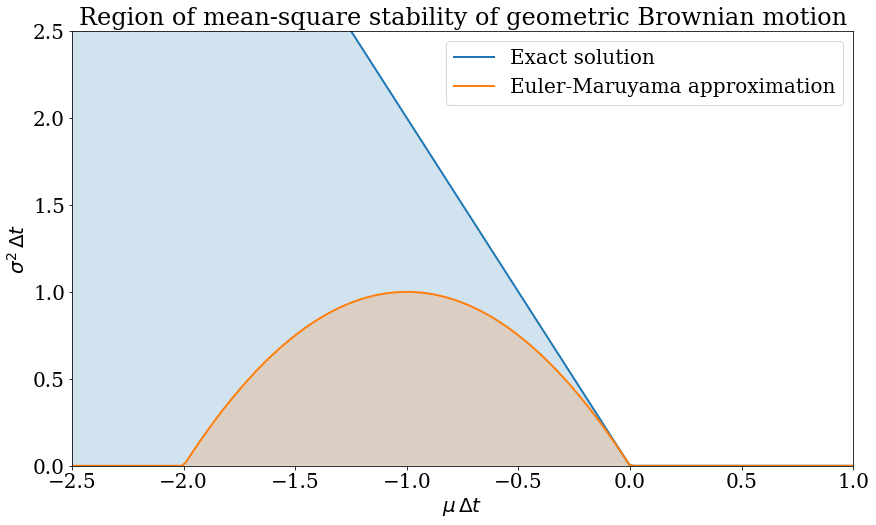

In [8]:
fig, ax = plt.subplots()
x = np.linspace(-2.5, 1, 200)  # x is μ Δt
y = np.maximum(0, - 2*x)  # y is σ² Δt
ax.plot(x, y, label="Exact solution")
ax.fill_between(x, 0*x, y, alpha=.2)
y = np.maximum(0, - 2*x - x**2)
ax.plot(x, y, label="Euler-Maruyama approximation")
ax.fill_between(x, 0*x, y, alpha=.2)
ax.set_title(r"Region of mean-square stability of geometric Brownian motion")
ax.set_ylabel(r"$\sigma^2 \, \Delta t$")
ax.set_xlabel(r"$\mu \, \Delta t$")
ax.set_xlim(-2.5, 1)
ax.set_ylim(0, 2.5)
ax.legend()
plt.show()

For the stochastic theta-method, the mean-square stability condition can be
shown to be the following (exercise!):
$$
\frac{|1 + (1-\theta)\mu \Delta t|^2 + \sigma^2 \Delta t}{|1 - \theta \mu \Delta t|^2} < 1.
$$
Below we plot the stability region for several values of $\theta$.
Note that the stability region becomes larger and larger as $\theta$ increases,
and that it coincides with that of the exact solution for $\theta = .5$.

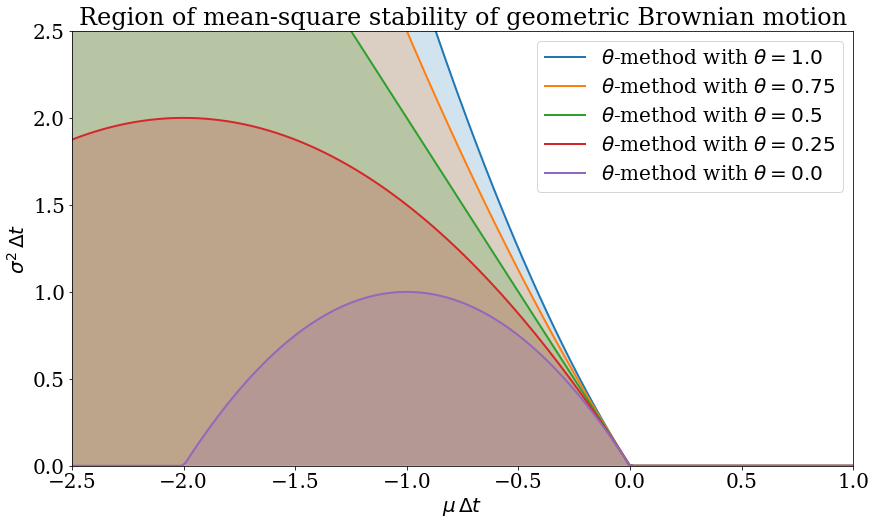

In [9]:
fig, ax = plt.subplots()
thetas = [0, .25, .5, .75, 1]
x = np.linspace(-2.5, 1, 200)  #
y = np.maximum(0, - 2*x)  #
for theta in np.flip(thetas):
    y = np.maximum(0, (1 - theta*x)**2 - (1 + (1 - theta)*x)**2)
    ax.plot(x, y, label=r"$\theta$-method with $\theta = {}$".format(theta))
    ax.fill_between(x, 0*y, y, alpha=.2)
ax.set_title(r"Region of mean-square stability of geometric Brownian motion")
ax.set_ylabel(r"$\sigma^2 \, \Delta t$")
ax.set_xlabel(r"$\mu \, \Delta t$")
ax.set_xlim(-2.5, 1)
ax.set_ylim(0, 2.5)
ax.legend()
plt.show()